In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


plt.rcParams.update({'font.size': 12})

np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000002D1D8302C50> at 0x000002D1EEF8BF00>

In [ ]:
def construct_anisotropic_hamiltonian(N, M, V, mu, J, anisotropy_factor=1.0, chemical_potential_loc=0):
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)
    
    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == chemical_potential_loc:
                H[alpha, alpha] -= mu

    # Tunneling term (level lowering)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            n = state[j]
            if n > 0:
                new_state = state.copy()
                new_state[j] = n - 1
                beta = state_to_index(new_state)
                H[alpha, beta] -= J
                H[beta, alpha] -= J

    # Interaction term (between neighbors)
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            a, b = state[i], state[i+1]
            if a == 1 and b == 0:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 0, 1
                beta = state_to_index(new_state)
                H[alpha, beta] += anisotropy_factor * V
                H[beta, alpha] += anisotropy_factor * V
            elif a == 2 and b == 1:
                new_state = state.copy()
                new_state[i], new_state[i+1] = 1, 2
                beta = state_to_index(new_state)
                H[alpha, beta] += V
                H[beta, alpha] += V

    return H


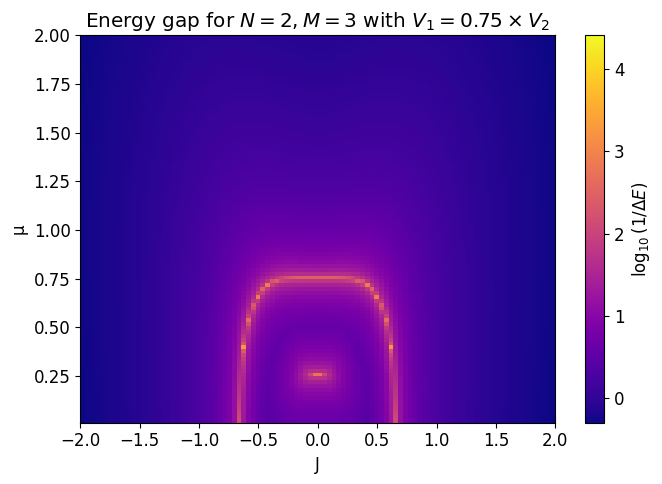

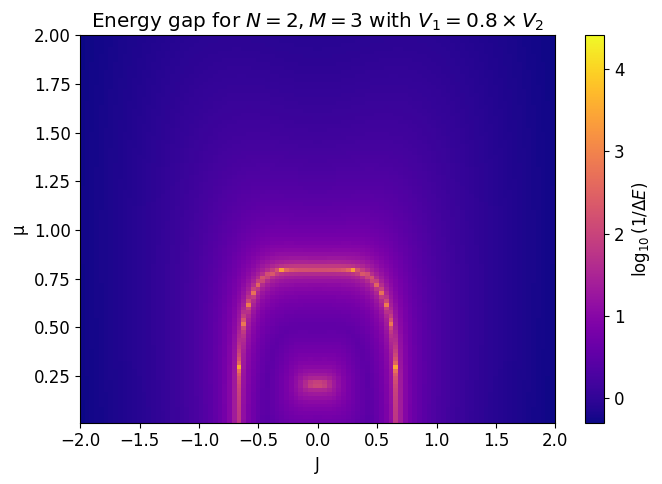

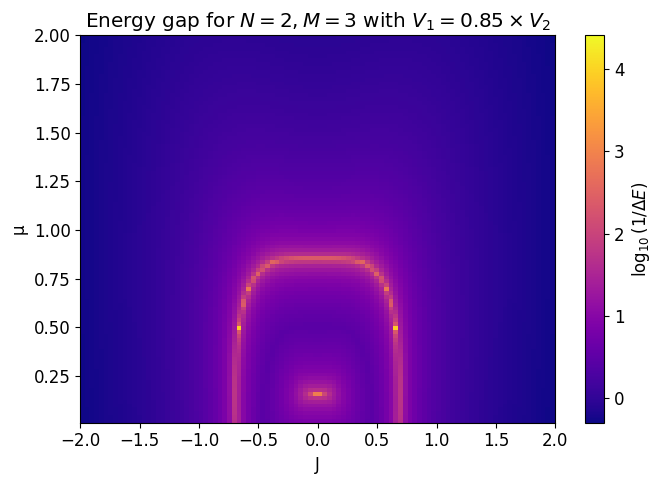

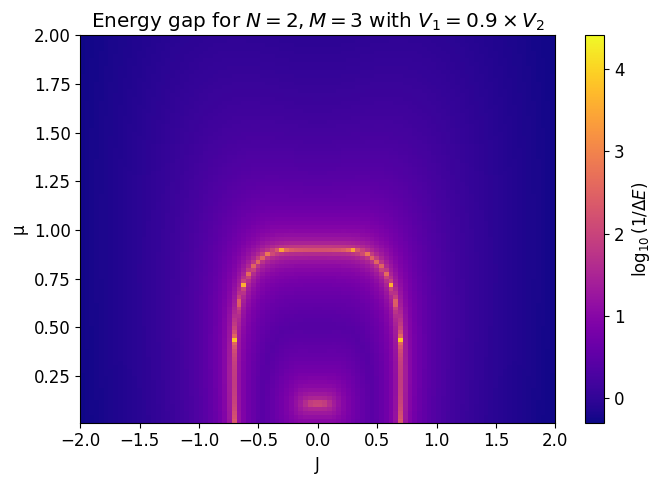

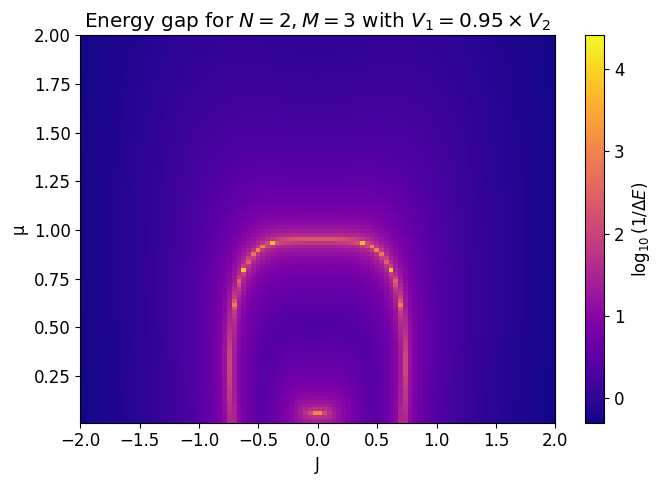

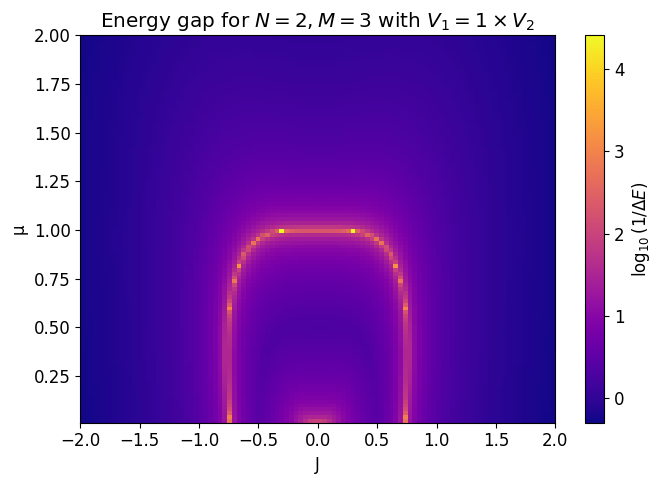

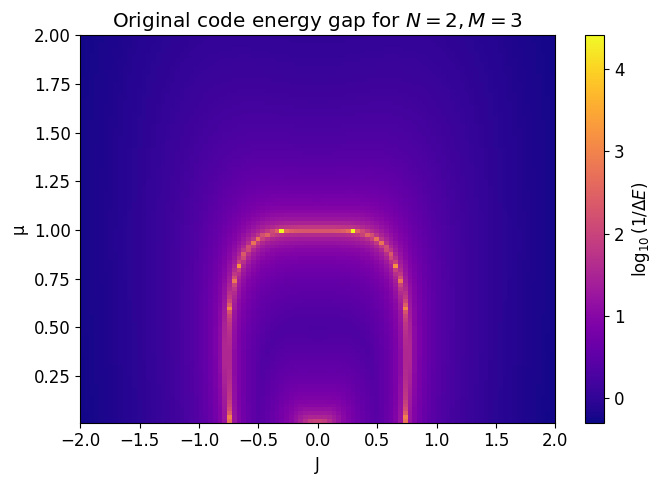

In [3]:
N = 2
M = 3
V = 1

Js = np.linspace(-2, 2, 100)
mus = np.linspace(0.01, 2, 100)
anisotropy_factors = [0.75, 0.8, 0.85, 0.9, 0.95, 1]

min_gap = 1e-7
log_gap_list = []

# Step 1: Precompute all log_gap arrays
for anisotropy_factor in anisotropy_factors:
    gap_grid = np.zeros((len(Js), len(mus)))
    for i, J in enumerate(Js):
        for j, mu in enumerate(mus):
            H = construct_anisotropic_hamiltonian(N=N, M=M, V=V, mu=mu, J=J, anisotropy_factor=anisotropy_factor)
            eigenvalues, _ = exact_diagonalize(H)
            energy_gap = eigenvalues[1] - eigenvalues[0]
            gap_grid[i, j] = energy_gap

    safe_gap = np.clip(gap_grid, min_gap, None)
    log_gap = np.log10(1 / safe_gap.T)
    log_gap_list.append(log_gap)

all_log_gaps = np.stack(log_gap_list)
vmin = np.min(all_log_gaps)
vmax = np.max(all_log_gaps)

extent = [Js[0], Js[-1], mus[0], mus[-1]]

for log_gap, anisotropy_factor in zip(log_gap_list, anisotropy_factors):
    plt.figure(figsize=(7, 5))
    plt.imshow(
        log_gap,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("J")
    plt.ylabel("μ")
    plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = {anisotropy_factor} \\times V_2$")
    plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
    plt.tight_layout()
    plt.show()

gap_grid = np.zeros((len(Js), len(mus)))
for i, J in enumerate(Js):
    for j, mu in enumerate(mus):
        H = construct_hamiltonian(N=N, M=M, V=V, mu=mu, J=J)
        eigenvalues, _ = exact_diagonalize(H)
        energy_gap = eigenvalues[1] - eigenvalues[0]
        gap_grid[i, j] = energy_gap

safe_gap = np.clip(gap_grid, min_gap, None)
log_gap = np.log10(1 / safe_gap.T)

plt.figure(figsize=(7, 5))
plt.imshow(
    log_gap,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='plasma',
    vmin=vmin,        
    vmax=vmax)
plt.xlabel("J")
plt.ylabel("μ")
plt.title(f"Original code energy gap for $N={N},M={M}$")
plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
plt.tight_layout()
plt.show()

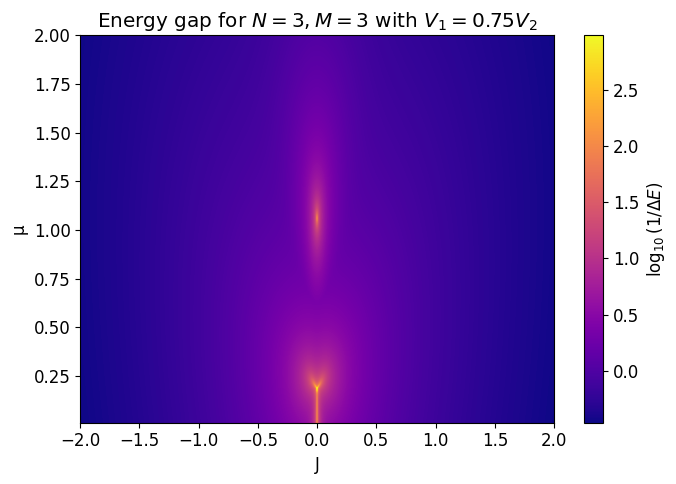

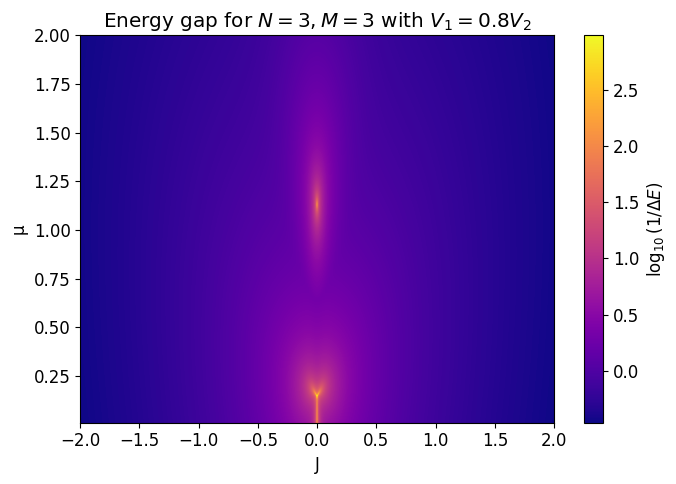

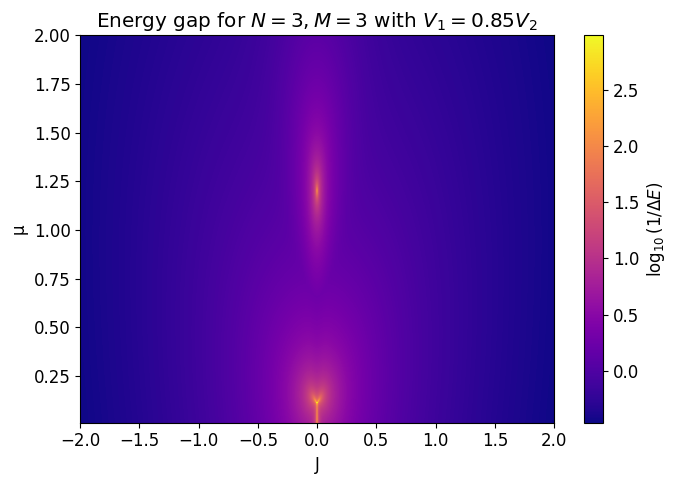

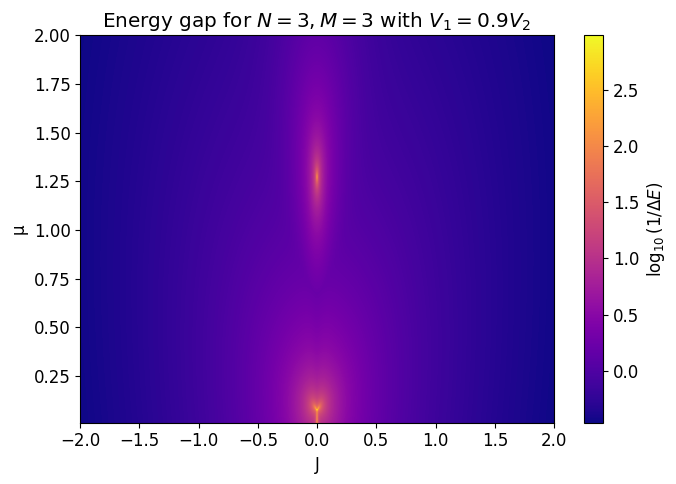

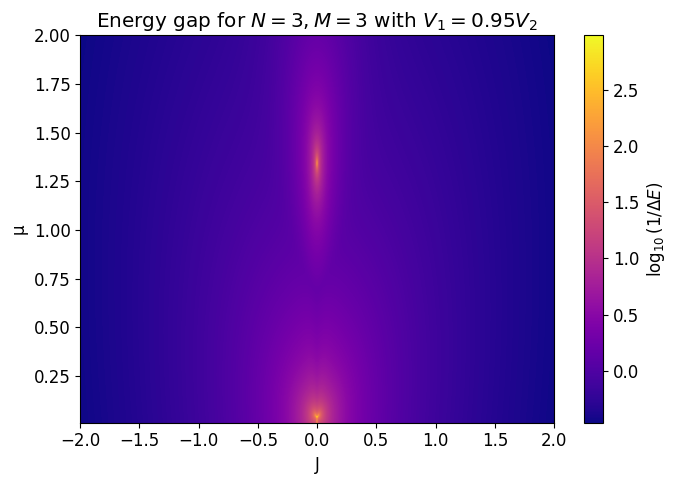

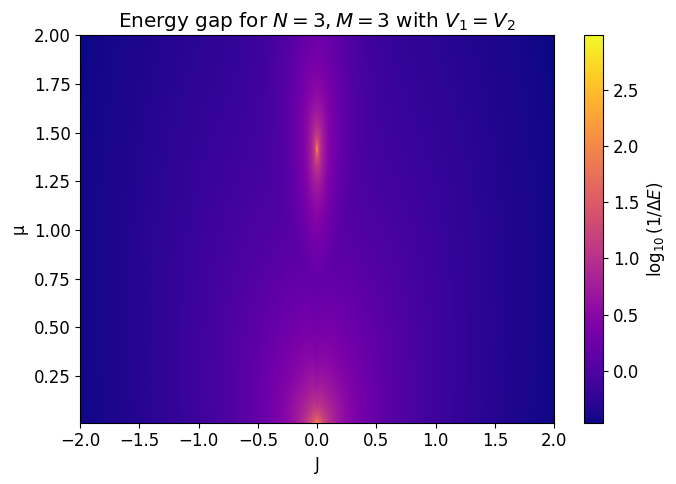

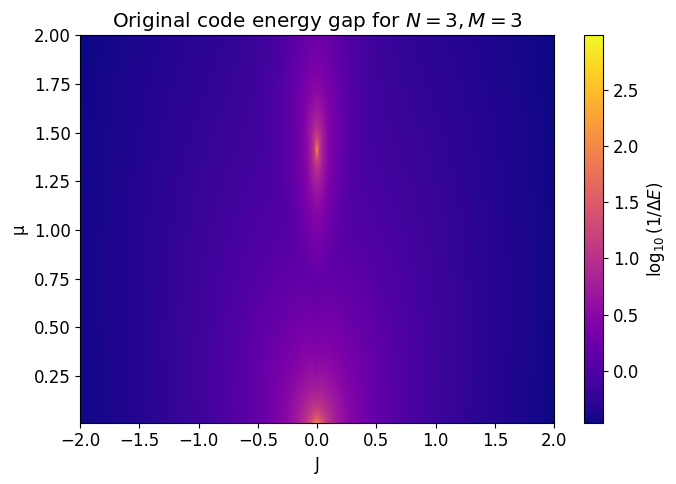

In [11]:
N = 3
M = 3
V = -1

Js = np.linspace(-2, 2, 500)
mus = np.linspace(0.01, 2, 500)
anisotropy_factors = [0.75, 0.8, 0.85, 0.9, 0.95, 1]

min_gap = 1e-7
log_gap_list = []

# Step 1: Precompute all log_gap arrays
for anisotropy_factor in anisotropy_factors:
    gap_grid = np.zeros((len(Js), len(mus)))
    for i, J in enumerate(Js):
        for j, mu in enumerate(mus):
            H = construct_anisotropic_hamiltonian(N=N, M=M, V=V, mu=mu, J=J, anisotropy_factor=anisotropy_factor)
            eigenvalues, _ = exact_diagonalize(H)
            energy_gap = eigenvalues[1] - eigenvalues[0]
            gap_grid[i, j] = energy_gap

    safe_gap = np.clip(gap_grid, min_gap, None)
    log_gap = np.log10(1 / safe_gap.T)
    log_gap_list.append(log_gap)

all_log_gaps = np.stack(log_gap_list)
vmin = np.min(all_log_gaps)
vmax = np.max(all_log_gaps)

extent = [Js[0], Js[-1], mus[0], mus[-1]]

for log_gap, anisotropy_factor in zip(log_gap_list, anisotropy_factors):
    plt.figure(figsize=(7, 5))
    plt.imshow(
        log_gap,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("J")
    plt.ylabel("μ")
    if anisotropy_factor == 1:
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = V_2$")
    else:
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = V_2$")
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = {anisotropy_factor} V_2$")
    plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
    plt.tight_layout()
    plt.show()

gap_grid = np.zeros((len(Js), len(mus)))
for i, J in enumerate(Js):
    for j, mu in enumerate(mus):
        H = construct_hamiltonian(N=N, M=M, V=V, mu=mu, J=J)
        eigenvalues, _ = exact_diagonalize(H)
        energy_gap = eigenvalues[1] - eigenvalues[0]
        gap_grid[i, j] = energy_gap

safe_gap = np.clip(gap_grid, min_gap, None)
log_gap = np.log10(1 / safe_gap.T)

plt.figure(figsize=(7, 5))
plt.imshow(
    log_gap,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='plasma',
    vmin=vmin,        
    vmax=vmax)
plt.xlabel("J")
plt.ylabel("μ")
plt.title(f"Original code energy gap for $N={N},M={M}$")
plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
plt.tight_layout()
plt.show()

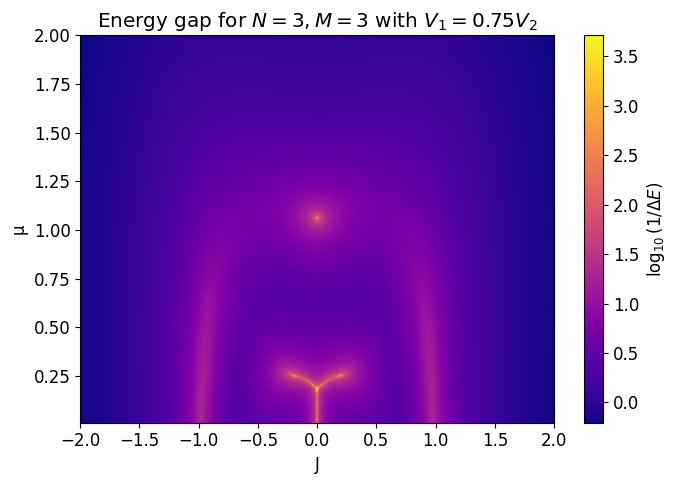

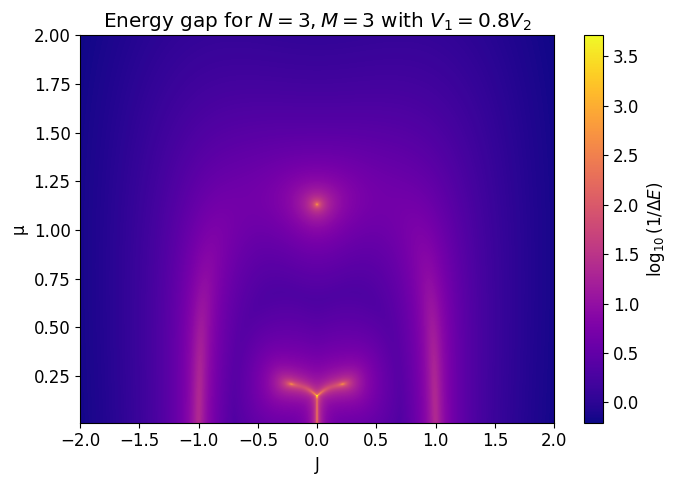

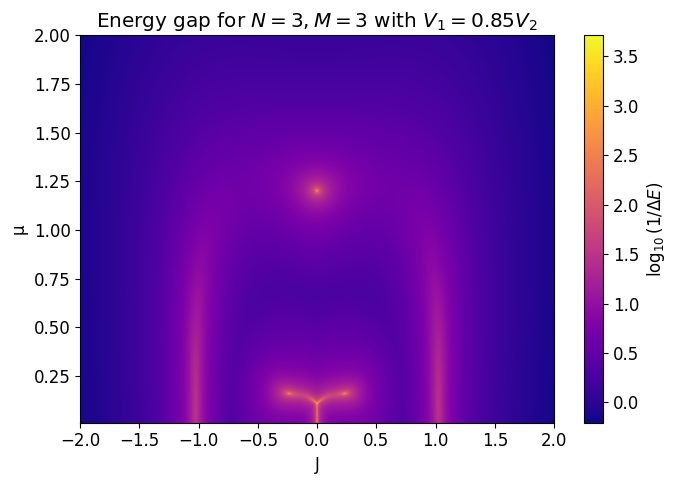

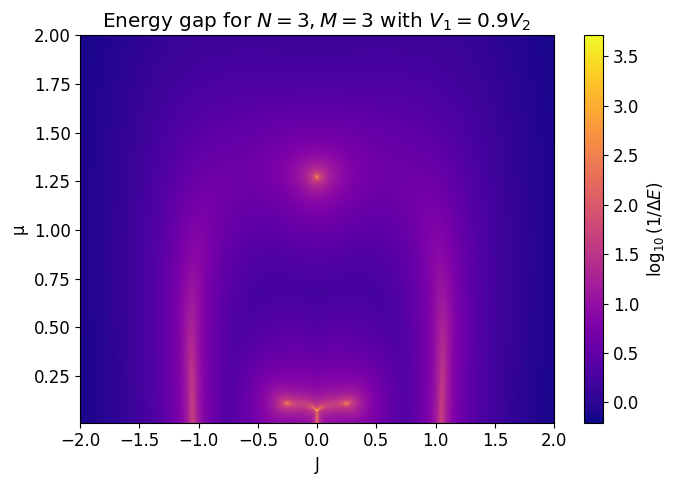

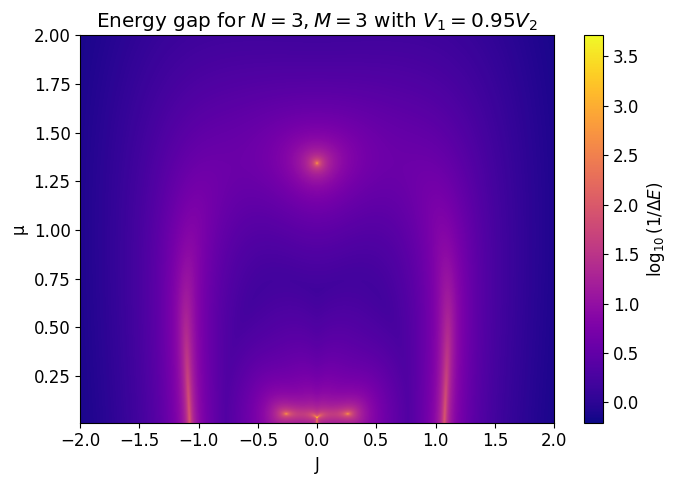

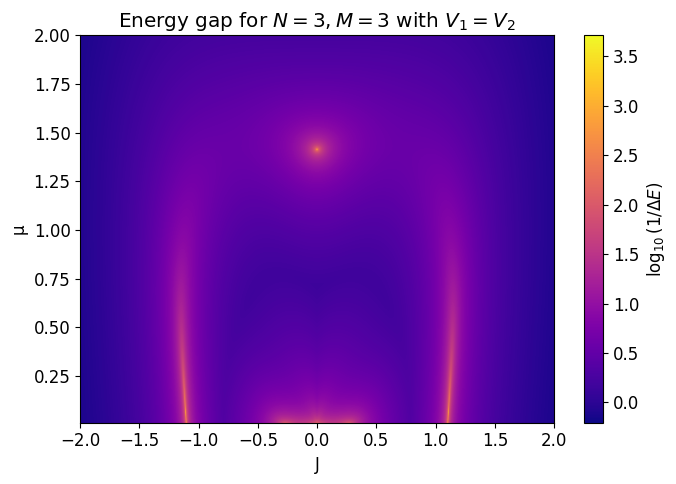

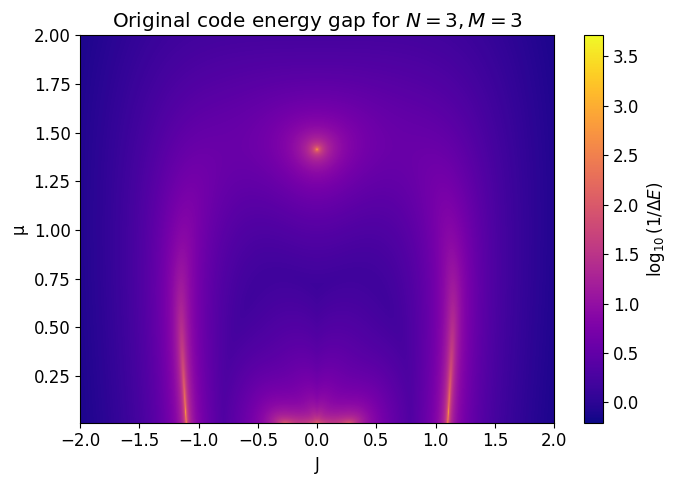

In [12]:
N = 3
M = 3
V = 1

Js = np.linspace(-2, 2, 500)
mus = np.linspace(0.01, 2, 500)
anisotropy_factors = [0.75, 0.8, 0.85, 0.9, 0.95, 1]

min_gap = 1e-7
log_gap_list = []

# Step 1: Precompute all log_gap arrays
for anisotropy_factor in anisotropy_factors:
    gap_grid = np.zeros((len(Js), len(mus)))
    for i, J in enumerate(Js):
        for j, mu in enumerate(mus):
            H = construct_anisotropic_hamiltonian(N=N, M=M, V=V, mu=mu, J=J, anisotropy_factor=anisotropy_factor)
            eigenvalues, _ = exact_diagonalize(H)
            energy_gap = eigenvalues[1] - eigenvalues[0]
            gap_grid[i, j] = energy_gap

    safe_gap = np.clip(gap_grid, min_gap, None)
    log_gap = np.log10(1 / safe_gap.T)
    log_gap_list.append(log_gap)

all_log_gaps = np.stack(log_gap_list)
vmin = np.min(all_log_gaps)
vmax = np.max(all_log_gaps)

extent = [Js[0], Js[-1], mus[0], mus[-1]]

for log_gap, anisotropy_factor in zip(log_gap_list, anisotropy_factors):
    plt.figure(figsize=(7, 5))
    plt.imshow(
        log_gap,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("J")
    plt.ylabel("μ")
    if anisotropy_factor == 1:
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = V_2$")
    else:
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = V_2$")
        plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = {anisotropy_factor} V_2$")
    plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
    plt.tight_layout()
    plt.show()

gap_grid = np.zeros((len(Js), len(mus)))
for i, J in enumerate(Js):
    for j, mu in enumerate(mus):
        H = construct_hamiltonian(N=N, M=M, V=V, mu=mu, J=J)
        eigenvalues, _ = exact_diagonalize(H)
        energy_gap = eigenvalues[1] - eigenvalues[0]
        gap_grid[i, j] = energy_gap

safe_gap = np.clip(gap_grid, min_gap, None)
log_gap = np.log10(1 / safe_gap.T)

plt.figure(figsize=(7, 5))
plt.imshow(
    log_gap,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='plasma',
    vmin=vmin,        
    vmax=vmax)
plt.xlabel("J")
plt.ylabel("μ")
plt.title(f"Original code energy gap for $N={N},M={M}$")
plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
plt.tight_layout()
plt.show()

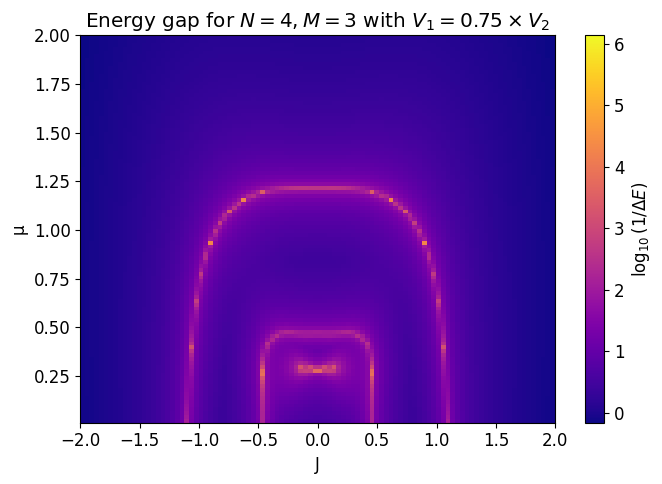

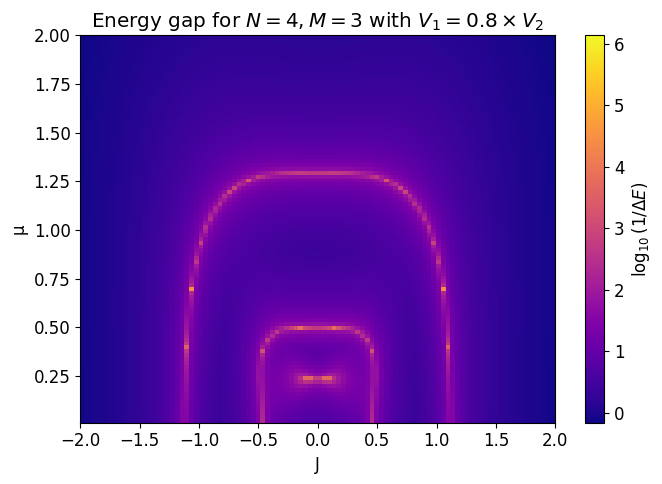

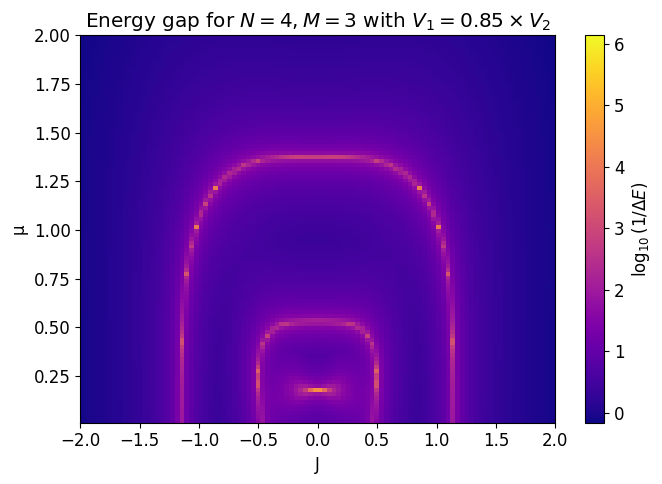

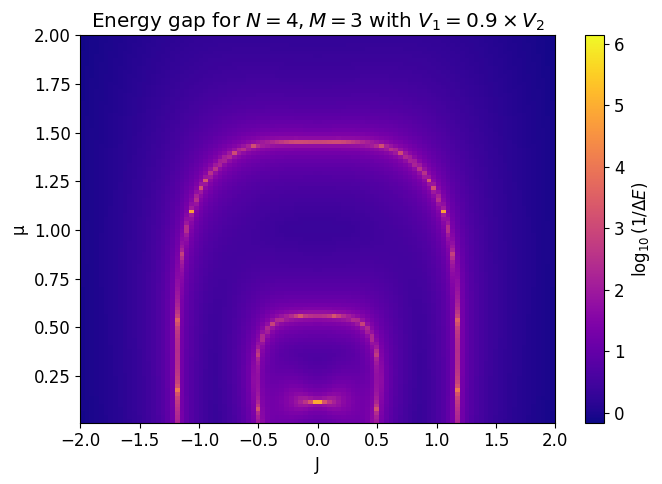

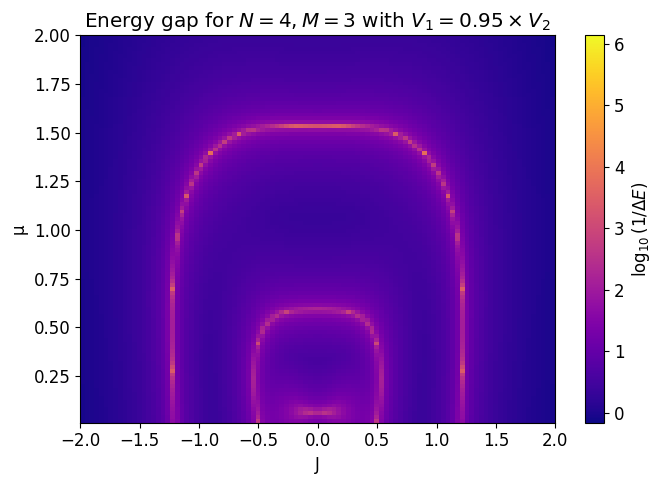

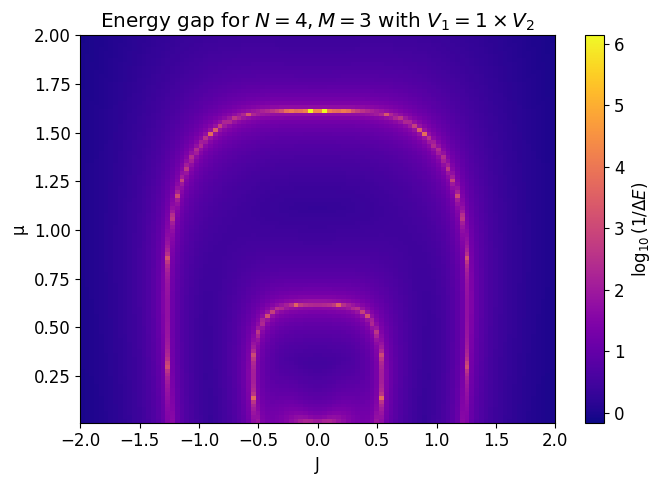

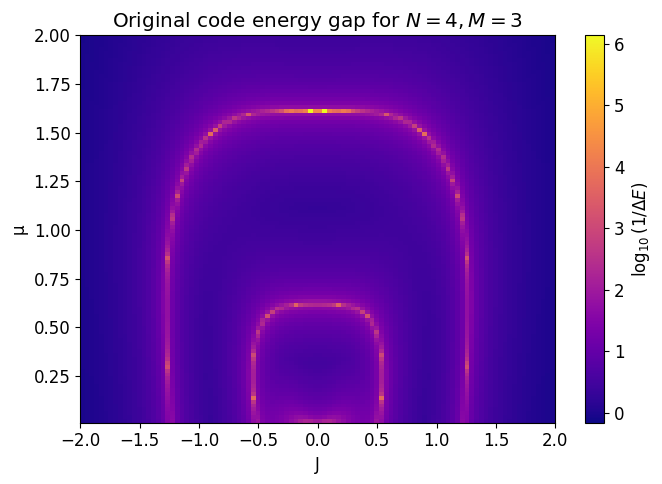

In [5]:
N = 4
M = 3
V = 1

Js = np.linspace(-2, 2, 100)
mus = np.linspace(0.01, 2, 100)
anisotropy_factors = [0.75, 0.8, 0.85, 0.9, 0.95, 1]

min_gap = 1e-7
log_gap_list = []

# Step 1: Precompute all log_gap arrays
for anisotropy_factor in anisotropy_factors:
    gap_grid = np.zeros((len(Js), len(mus)))
    for i, J in enumerate(Js):
        for j, mu in enumerate(mus):
            H = construct_anisotropic_hamiltonian(N=N, M=M, V=V, mu=mu, J=J, anisotropy_factor=anisotropy_factor)
            eigenvalues, _ = exact_diagonalize(H)
            energy_gap = eigenvalues[1] - eigenvalues[0]
            gap_grid[i, j] = energy_gap

    safe_gap = np.clip(gap_grid, min_gap, None)
    log_gap = np.log10(1 / safe_gap.T)
    log_gap_list.append(log_gap)

all_log_gaps = np.stack(log_gap_list)
vmin = np.min(all_log_gaps)
vmax = np.max(all_log_gaps)

extent = [Js[0], Js[-1], mus[0], mus[-1]]

for log_gap, anisotropy_factor in zip(log_gap_list, anisotropy_factors):
    plt.figure(figsize=(7, 5))
    plt.imshow(
        log_gap,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("J")
    plt.ylabel("μ")
    plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = {anisotropy_factor} \\times V_2$")
    plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
    plt.tight_layout()
    plt.show()

gap_grid = np.zeros((len(Js), len(mus)))
for i, J in enumerate(Js):
    for j, mu in enumerate(mus):
        H = construct_hamiltonian(N=N, M=M, V=V, mu=mu, J=J)
        eigenvalues, _ = exact_diagonalize(H)
        energy_gap = eigenvalues[1] - eigenvalues[0]
        gap_grid[i, j] = energy_gap

safe_gap = np.clip(gap_grid, min_gap, None)
log_gap = np.log10(1 / safe_gap.T)

plt.figure(figsize=(7, 5))
plt.imshow(
    log_gap,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='plasma',
    vmin=vmin,        
    vmax=vmax)
plt.xlabel("J")
plt.ylabel("μ")
plt.title(f"Original code energy gap for $N={N},M={M}$")
plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
plt.tight_layout()
plt.show()

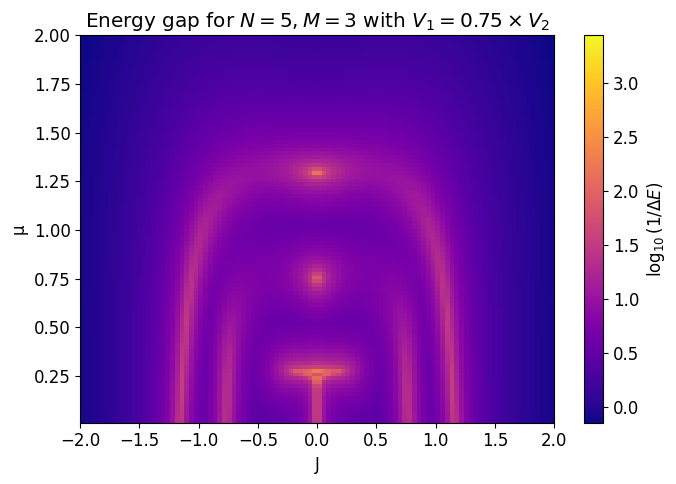

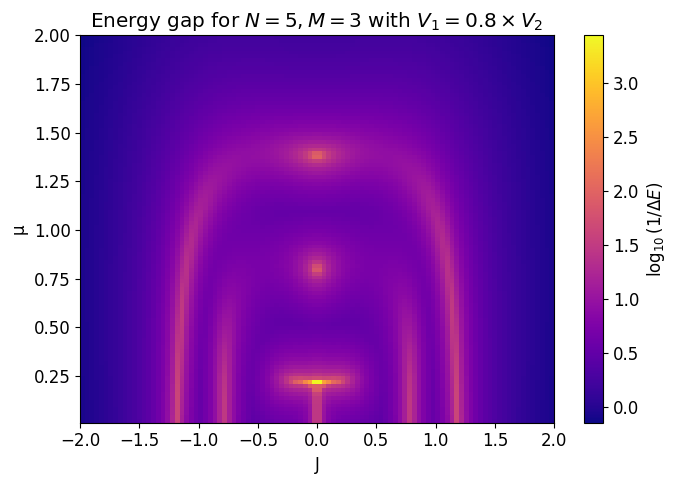

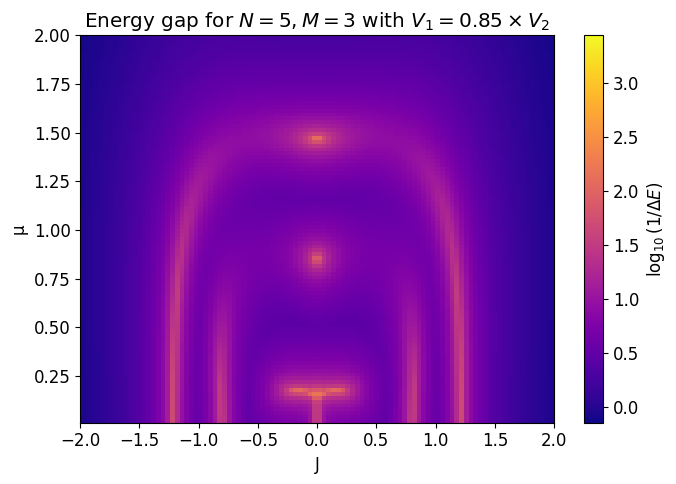

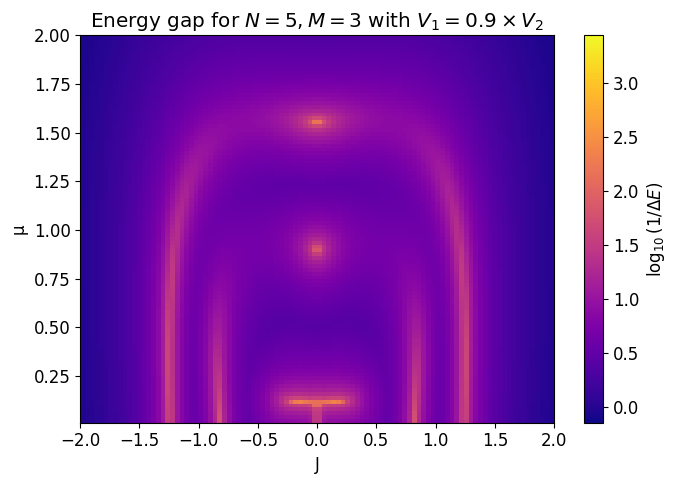

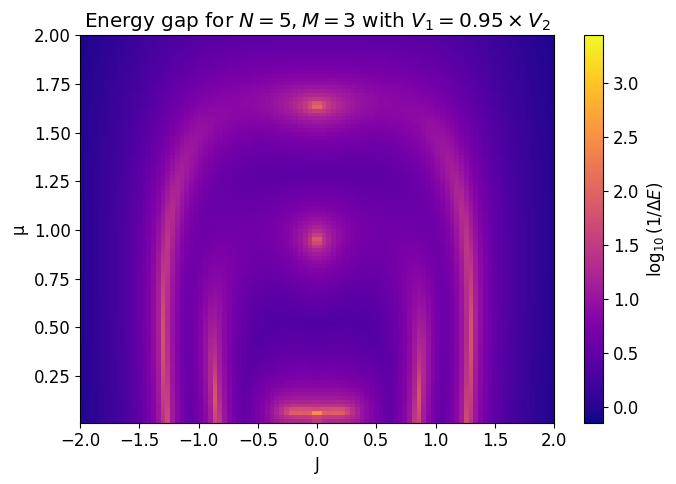

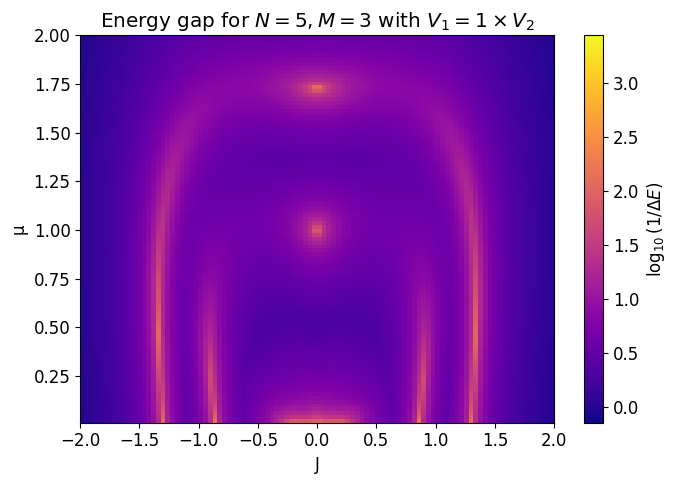

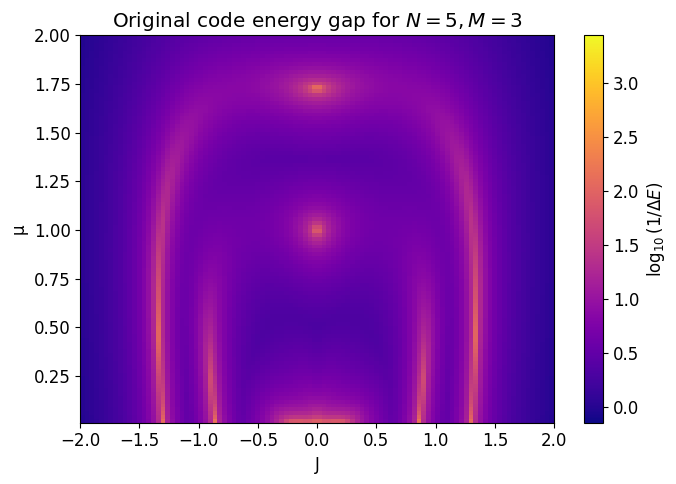

In [6]:
N = 5
M = 3
V = 1

Js = np.linspace(-2, 2, 100)
mus = np.linspace(0.01, 2, 100)
anisotropy_factors = [0.75, 0.8, 0.85, 0.9, 0.95, 1]

min_gap = 1e-7
log_gap_list = []

# Step 1: Precompute all log_gap arrays
for anisotropy_factor in anisotropy_factors:
    gap_grid = np.zeros((len(Js), len(mus)))
    for i, J in enumerate(Js):
        for j, mu in enumerate(mus):
            H = construct_anisotropic_hamiltonian(N=N, M=M, V=V, mu=mu, J=J, anisotropy_factor=anisotropy_factor)
            eigenvalues, _ = exact_diagonalize(H)
            energy_gap = eigenvalues[1] - eigenvalues[0]
            gap_grid[i, j] = energy_gap

    safe_gap = np.clip(gap_grid, min_gap, None)
    log_gap = np.log10(1 / safe_gap.T)
    log_gap_list.append(log_gap)

all_log_gaps = np.stack(log_gap_list)
vmin = np.min(all_log_gaps)
vmax = np.max(all_log_gaps)

extent = [Js[0], Js[-1], mus[0], mus[-1]]

for log_gap, anisotropy_factor in zip(log_gap_list, anisotropy_factors):
    plt.figure(figsize=(7, 5))
    plt.imshow(
        log_gap,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("J")
    plt.ylabel("μ")
    plt.title(f"Energy gap for $N={N},M={M}$ with $V_1 = {anisotropy_factor} \\times V_2$")
    plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
    plt.tight_layout()
    plt.show()

gap_grid = np.zeros((len(Js), len(mus)))
for i, J in enumerate(Js):
    for j, mu in enumerate(mus):
        H = construct_hamiltonian(N=N, M=M, V=V, mu=mu, J=J)
        eigenvalues, _ = exact_diagonalize(H)
        energy_gap = eigenvalues[1] - eigenvalues[0]
        gap_grid[i, j] = energy_gap

safe_gap = np.clip(gap_grid, min_gap, None)
log_gap = np.log10(1 / safe_gap.T)

plt.figure(figsize=(7, 5))
plt.imshow(
    log_gap,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='plasma',
    vmin=vmin,        
    vmax=vmax)
plt.xlabel("J")
plt.ylabel("μ")
plt.title(f"Original code energy gap for $N={N},M={M}$")
plt.colorbar(label=r"$\log_{10}(1/\Delta E)$")
plt.tight_layout()
plt.show()